In [18]:
import torch
import torch.nn as nn
from torch.utils.tensorboard.writer import SummaryWriter
import app.training.networks as net
from app.data_gen.surface_gen import generate_custom_130_point_iv_surface
from app.data_gen.models import GenerationParams
from app.data_gen.sampling import sample_moneyness, sample_maturities
from app.recalibration.recalibration import simulate_ivs_with_neural_network, simulate_ivs_analyticaly
from app.training.dataset.data_module import IVS_DataModule
from app.training.dataset.dual_input_data_module import DualInput_IVS_DataModule

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os

## Plot Neural Networks

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add, ELU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


def get_residual_nn1(name):
  
  inputs = Input(shape=(1024,), name="ResBlock_NN1_Input")
  
  # Residual block: 4 Dense -> BatchNorm -> ELU layers
  x = Dense(1024)(inputs)
  x = ELU()(x)
  x = Dense(1024)(x)
  x = ELU()(x)
  x = Dense(1024)(x)
  x = ELU()(x)
  x = Dense(1024)(x)
  outputs = ELU(name="ResBlock_NN1_Output")(x)
  
  return Model(inputs=inputs, outputs=outputs, name=name)

def create_NN1(input_dim=41, hidden_dim=1024, output_dim=130):
    """
    NN1 Architecture:
      - Input head: Dense(hidden_dim) with ELU activation.
      - Residual block: Four Dense(hidden_dim) layers (each with ELU) added to the input head.
      - Final processing: ELU activation followed by Dense(output_dim).
    """
    inputs = Input(shape=(input_dim,), name="NN1_Input")
    
    # Input head
    x = Dense(hidden_dim, name="Input_Head_Dense")(inputs)
    x = ELU(name="Input_Head_ELU")(x)
    residual = x  # Save for the skip connection

    # Residual block: 4 Dense+ELU layers
    # for i in range(1, 5):
    #     x = Dense(hidden_dim, name=f"Residual_Block_Dense_{i}")(x)
    #     x = ELU(name=f"Residual_Block_ELU_{i}")(x)
    
    # Add the skip connection
    x = get_residual_nn1(name="NN1_Residual_Block")(x)
    
    x = Add(name="Residual_Add")([x, residual])
    
    # Final activation and output layer
    x = ELU(name="Final_ELU")(x)
    outputs = Dense(output_dim, name="NN1_Output")(x)
    
    model = Model(inputs=inputs, outputs=outputs, name="NN1")
    return model

# Create and plot the NN1 model
model_nn1 = get_residual_nn1(name="NN1_Residual_Block")
plot_model(model_nn1, to_file='NN1_ResBlock.png', show_shapes=True, show_layer_names=True)
x=1


In [3]:
from tensorflow.keras.layers import BatchNormalization, Concatenate, Lambda

# Custom stretched sigmoid activation function
def stretched_sigmoid(min_value, max_value, name):
    """
    Returns a Lambda layer that applies a stretched sigmoid:
      f(x) = min_value + (max_value - min_value)*sigmoid(x)
    """
    return Lambda(lambda x: min_value + (max_value - min_value) * tf.keras.backend.sigmoid(x),
                  name=f"StretchedSigmoid_{name}")
    
def get_residual_nn2(name):
  
  inputs = Input(shape=(1024,), name="ResBlock_NN2_Input")
  
  # Residual block: 4 Dense -> BatchNorm -> ELU layers
  x = Dense(1024)(inputs)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dense(1024)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dense(1024)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dense(1024)(x)
  x = BatchNormalization()(x)
  outputs = ELU(name="ResBlock_NN2_Output")(x)
  
  return Model(inputs=inputs, outputs=outputs, name=name)

def create_NN2(input_size=133, hidden_size=1024, output_size=10):
    """
    NN2 Architecture:
      - Input head: Dense -> BatchNormalization -> ELU.
      - Residual block: 4 layers each of (Dense -> BatchNormalization -> ELU) with a skip connection.
      - Additional processing: ELU -> Dense (reducing to output_size) -> BatchNormalization.
      - Two branches:
          * nu_layer: Dense(output_size/2) + StretchedSigmoid(-0.3, 0.3)
          * delta_layer: Dense(output_size/2) + StretchedSigmoid(0.2, 0.3)
      - Final output: Concatenation of the two branches.
      
      **Note:** `output_size` must be even.
    """
    assert output_size % 2 == 0, "output_size must be even."
    
    inputs = Input(shape=(input_size,), name="NN2_Input")
    
    # Input head with Batch Normalization
    x = Dense(hidden_size)(inputs)
    x = BatchNormalization()(x)
    x = ELU(name="ELU")(x)
    residual = x  # Save for the skip connection

    # # Residual block: 4 Dense -> BatchNorm -> ELU layers
    # for i in range(1, 5):
    #     x = Dense(hidden_size, name=f"Residual_Block_Dense_{i}")(x)
    #     x = BatchNormalization(name=f"Residual_Block_BN_{i}")(x)
    #     x = ELU(name=f"Residual_Block_ELU_{i}")(x)
    
    x = get_residual_nn2(name="NN2_Residual_Block")(x)
    
    # Add skip connection
    x = Add(name="Residual_Add")([x, residual])
    
    # Additional processing layers
    x = ELU()(x)
    x = Dense(output_size)(x)
    x = BatchNormalization()(x)
    
    # Branch for nu (using StretchedSigmoid with range [-0.3, 0.3])
    nu = Dense(output_size // 2, name="nu_Dense")(x)
    nu = stretched_sigmoid(-0.3, 0.3, name="nu")(nu)
    
    # Branch for delta (using StretchedSigmoid with range [0.2, 0.3])
    delta = Dense(output_size // 2, name="delta_Dense")(x)
    delta = stretched_sigmoid(0.2, 0.3, "delta")(delta)
    
    # Concatenate branches to form final output
    outputs = Concatenate(name="NN2_Output")([nu, delta])
    
    model = Model(inputs=inputs, outputs=outputs, name="NN2")
    return model

# Create and plot the NN2 model
# model_nn2 = create_NN2()
model_nn2 = get_residual_nn2(name="ResBlock_NN2")
plot_model(model_nn2, to_file='NN2_ResBlock_sep.png', show_shapes=True, show_layer_names=True)
x=1


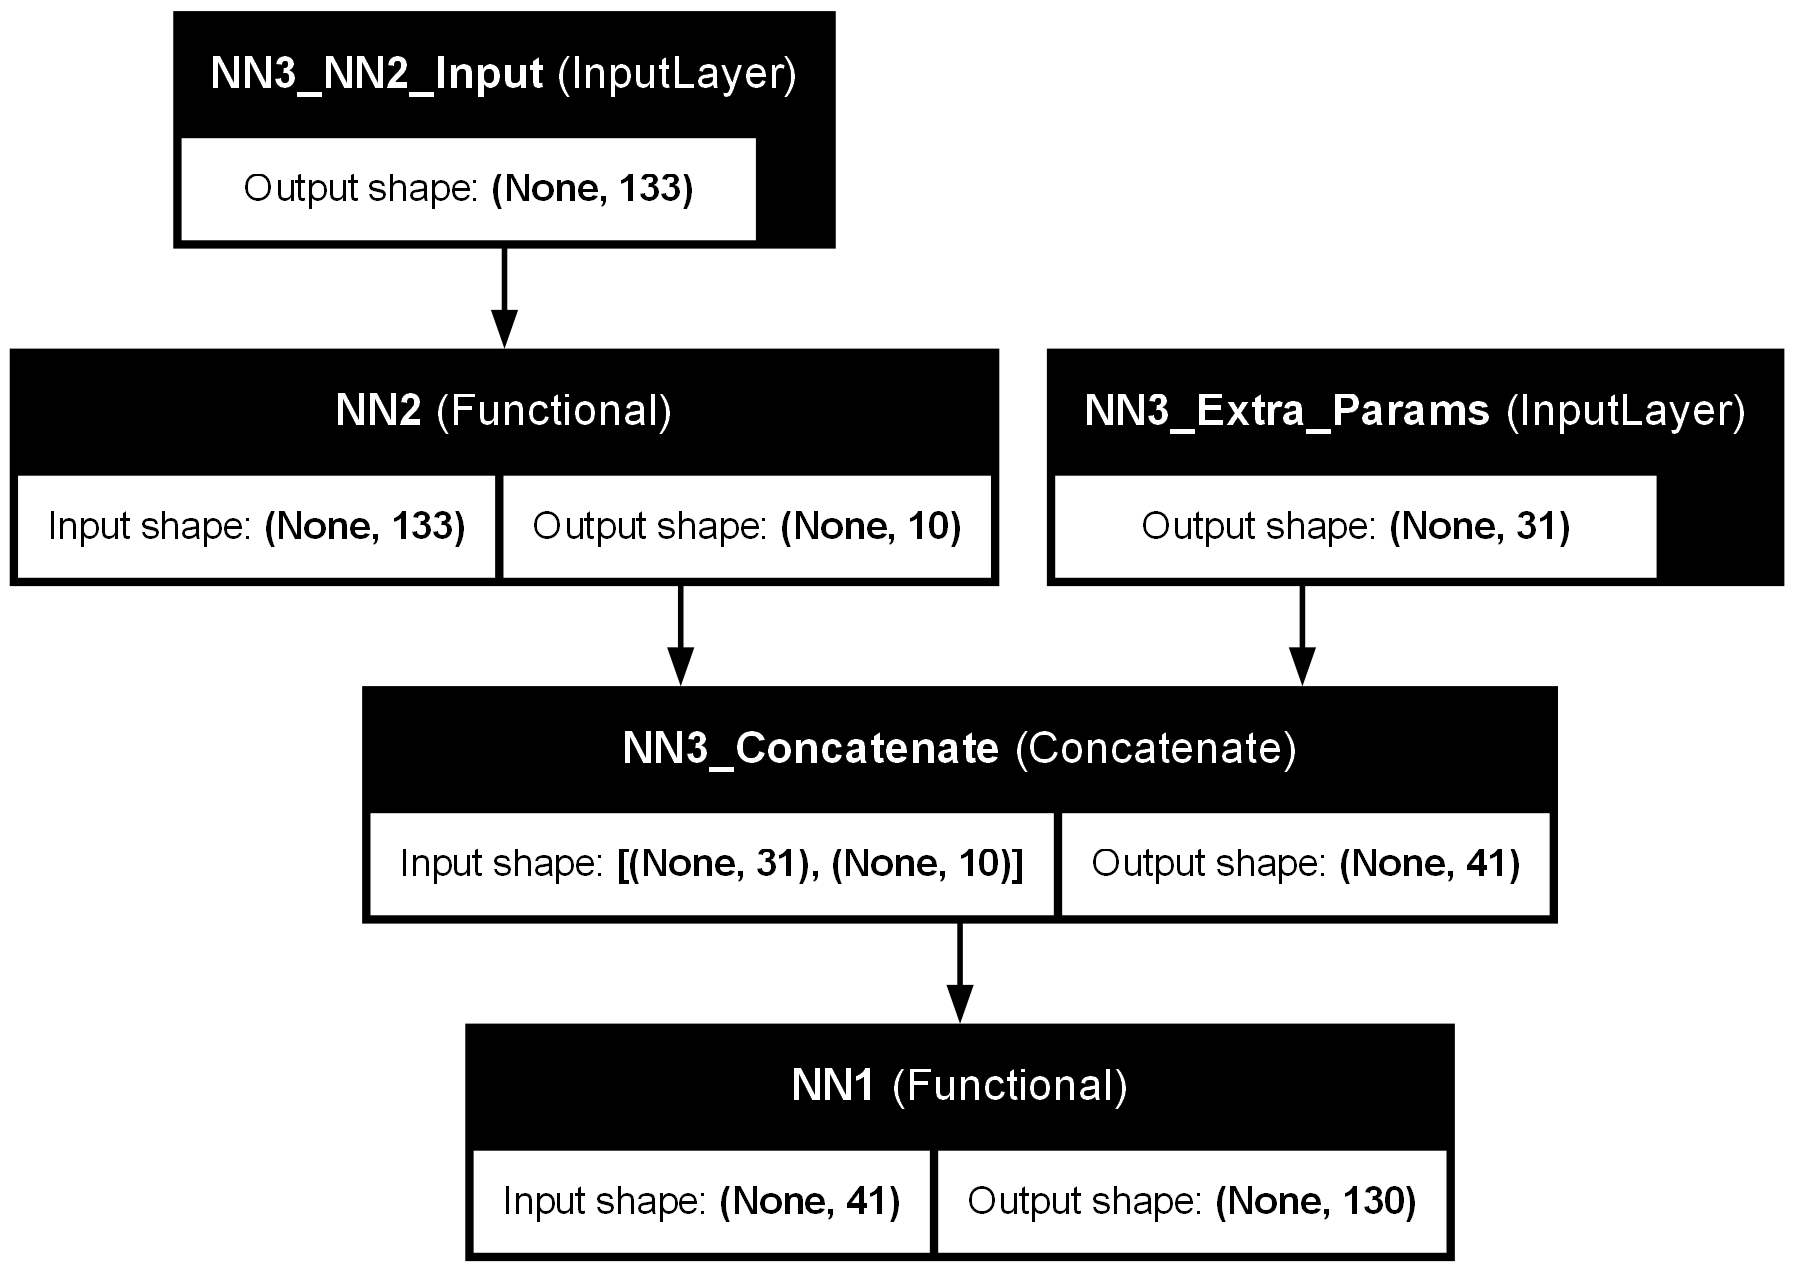

In [9]:
def create_NN3(nn1, nn2, extra_params_dim=31):
    """
    NN3 Architecture:
      - Two inputs:
          * `nn2_input`: fed to NN2 (shape: [133])
          * `nn1_extra_params`: additional parameters (shape: [extra_params_dim])
      - NN2 processes its input to produce a 10-dimensional output.
      - The output of NN2 is concatenated with `nn1_extra_params` to create a 41-dimensional vector.
      - This concatenated vector is then fed into NN1 to produce the final 130-dimensional output.
    """
    # Define two inputs
    input_nn2 = Input(shape=(133,), name="NN3_NN2_Input")
    input_extra = Input(shape=(extra_params_dim,), name="NN3_Extra_Params")
    
    # Get NN2 output
    nn2_out = nn2(input_nn2)
    
    # Concatenate extra parameters and NN2 output
    nn1_input = Concatenate(name="NN3_Concatenate")([input_extra, nn2_out])
    
    # Feed the combined input into NN1
    outputs = nn1(nn1_input)
    
    model = Model(inputs=[input_nn2, input_extra], outputs=outputs, name="NN3")
    return model

# Create the composite NN3 model using the previously defined NN1 and NN2 models.
model_nn3 = create_NN3(model_nn1, model_nn2, extra_params_dim=31)
plot_model(model_nn3, to_file='NN3_model.png', show_shapes=True, show_layer_names=True)


In [ ]:
class CustomModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(CustomModel, self).__init__()
        
        # Input Layer
        self.input_linear = nn.Linear(input_dim, hidden_dim)
        self.input_activation = nn.ELU()

        # Hidden residual block (Unrolled)
        self.hidden_linear_1 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_activation_1 = nn.ELU()
        
        self.hidden_linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_activation_2 = nn.ELU()
        
        self.hidden_linear_3 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_activation_3 = nn.ELU()
        
        self.hidden_linear_4 = nn.Linear(hidden_dim, hidden_dim)
        self.hidden_activation_4 = nn.ELU()

        # Output Layer
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Input Layer
        residual = self.input_activation(self.input_linear(x))

        # Hidden Residual Block (Unrolled)
        x = self.hidden_activation_1(self.hidden_linear_1(residual))
        x = self.hidden_activation_2(self.hidden_linear_2(x))
        x = self.hidden_activation_3(self.hidden_linear_3(x))
        x = self.hidden_activation_4(self.hidden_linear_4(x))

        # Add Residual Connection
        x = x + residual  # Skip connection

        # Output Layer
        return self.output_layer(nn.ELU()(x))
    
# Create model
input_dim = 41
hidden_dim = 1024
output_dim = 130
model = net.NN1Residual()

# Create a TensorBoard writer
writer = SummaryWriter("runs/")

# Generate a dummy input tensor (batch_size=1, features=41)
dummy_input = torch.randn(1, input_dim)

# traced= torch.jit.trace(model, dummy_input)

# Log model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close writer
writer.close()

print("Model graph has been written to TensorBoard.")

Model graph has been written to TensorBoard.


c:\Users\USUARIO\PycharmProjects\MathThesis\venv-math\lib\site-packages\torch\jit\_trace.py:685: UserWarning: The input to trace is already a ScriptModule, tracing it is a no-op. Returning the object as is.
  warnings.warn(


## $NN_1$ Results plotting

In [19]:
nn2 = net.NN3.load_from_checkpoint(os.path.join("models","nn3","version_3","checkpoints", "best_model-epoch=22-val_loss=0.00.ckpt"), nn1=net.NN1Residual(), nn2=net.NN2()).nn2
nn1 = net.NN1Residual.load_from_checkpoint(os.path.join("models","nn1", "version_33", "checkpoints", "best_model-epoch=141-val_loss=0.00.ckpt"))

In [20]:
dataSet_NN1 = IVS_DataModule()
dataSet_NN2 = DualInput_IVS_DataModule()
dataSet_NN1.prepare_data()
dataSet_NN2.prepare_data()
scaler_nn1 = dataSet_NN1.min_max_scaler
scaler_nn2 = dataSet_NN2.scaler1

#### 1st CASE

({'xlim': (np.float64(-0.06732305936073059), np.float64(1.2919805936073059)), 'autoscalex_on': True, 'ylim': (np.float64(0.7708333333333334), np.float64(1.2291666666666667)), 'autoscaley_on': True, 'zlim': (np.float64(0.15), np.float64(0.58)), 'autoscalez_on': False}, (30, -60, 0))


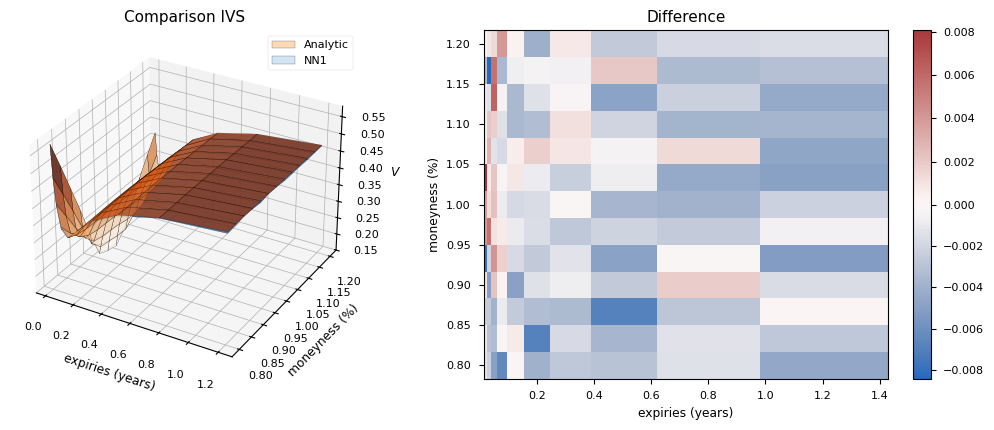

In [ ]:
spot_price = 100

tau_grid = sample_maturities(10)
moneyness_grid = sample_moneyness(13)
jump_means = np.array([0.159]*5)
jump_variances = np.array([0.205]*5)

params = {'r': 0.0205,
          'q': 0.03,
          'v0': 0.0001,
          'kappa': 7.797,
          'theta': 0.247,
          'sigma': 0.280,
          'rho': 0.042,
          'lambda_p': 0.081}

params.update({f"tau_{i}": tau for i, tau in enumerate(tau_grid, start=1)})
params.update({f"m_{i}": m for i, m in enumerate(moneyness_grid, start=1)})
params.update({f"nu_{i}": nu for i, nu in enumerate(jump_means, start=1)})
params.update({f"delta_{i}": delta for i, delta in enumerate(jump_variances, start=1)})

data_point, generation_params = simulate_ivs_analyticaly(params=params, moneyness_grid=moneyness_grid, tau_grid=tau_grid, 
                         spot_price=spot_price, jump_means=jump_means, jump_variances=jump_variances)

ivs_nn = simulate_ivs_with_neural_network(parameters=params, model=nn1, new_V=None, scaler=scaler_nn1)

# Plot the surface
iv_matrix_analytic = np.array(data_point["implied_vol_surface"]).reshape(len(tau_grid), len(moneyness_grid))
iv_matrix_nn = np.array(ivs_nn.cpu().detach()).reshape(len(tau_grid), len(moneyness_grid))

X, Y = np.meshgrid(np.array(tau_grid) / 365.0, moneyness_grid)

Z_diff = iv_matrix_nn - iv_matrix_analytic

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['grid.linewidth'] = 0.5  # try a value like 0.1 instead of 0.01
plt.rcParams['axes.titlesize'] = 11
fig = plt.figure(figsize=plt.figaspect(0.4))

# 3D Surface Plot
ax1: Axes3D = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, iv_matrix_analytic.T, cmap='Oranges', alpha=0.7, edgecolor='k', linewidth=0.2, antialiased=True)
surf2 = ax1.plot_surface(X, Y, iv_matrix_nn.T, cmap='Blues', alpha=0.7, edgecolor='k', linewidth=0.2, antialiased=True)
ax1.set_xlabel("expiries (years)")
ax1.set_ylabel("moneyness (%)")
ax1.set_zlim(0.15, 0.58)
ax1.set_zlabel("$V$")
ax1.set_title("Comparison IVS")
ax1.legend(["Analytic", "NN1"], framealpha=1)
print(ax1._get_view())
# cbar1 = fig.colorbar(surf1, ax=ax1, location='right', shrink=0.6, pad=0.12, cmap="Oranges")
# cbar1.set_ticks(np.round(np.linspace(iv_matrix_analytic.min(), 0.48, 5), 2))
# cbar2 = fig.colorbar(surf2, ax=ax1, location='right', shrink=0.6, pad=0.12, cmap="Blues")
# cbar2.set_ticks(np.round(np.linspace(iv_matrix_nn.min(), 0.475, 5), 2))
# ax1.view_init(azim=90)


# Heatmap
ax2 = fig.add_subplot(122)
# plt.pcolormesh
# im = ax2.imshow(Z_diff, aspect=4, interpolation='auto', interpolation_stage='data', origin='lower', cmap="coolwarm",
                    # extent=(X.min(), X.max(), Y.min(), Y.max()))
norm = colors.TwoSlopeNorm(vcenter=0)
im  = ax2.pcolormesh(
    X, Y, Z_diff.T,
    cmap='vlag',  # A perceptually uniform colormap ideal for continuous data
    shading='auto', norm=norm
)
cbar_diff = fig.colorbar(im, ax=ax2)
# cbar_diff.set_label("Difference")
# cbar_diff.set_ticks(np.round(np.linspace(Z_diff.min(), Z_diff.max(), 5), 4))
ax2.set_xlabel("expiries (years)")
ax2.set_ylabel("moneyness (%)")
ax2.set_title("Difference")

plt.tight_layout()
plt.savefig("nn1_case1.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

In [54]:
import matplotlib.animation as animation
import numpy as np

def update_view(angle):
    # Update only the 3D plot's azimuth while keeping the rest of the figure intact.
    ax1.view_init(azim=angle)
    return ax1,

# Create an animation that rotates the azimuth from 0 to 360 degrees.
# Adjust the frames and interval as desired.
anim = animation.FuncAnimation(fig, update_view, frames=np.linspace(-60, 300, 180), interval=50)

# Save the animation as a GIF (requires Pillow installed).
anim.save('rotation1.gif', writer='pillow', dpi=300)

#### 2ND Case

({'xlim': (np.float64(-0.06732305936073059), np.float64(1.2919805936073059)), 'autoscalex_on': True, 'ylim': (np.float64(0.7708333333333334), np.float64(1.2291666666666667)), 'autoscaley_on': True, 'zlim': (np.float64(0.32475895906519014), np.float64(0.6635196340276613)), 'autoscalez_on': True}, (30, -60, 0))


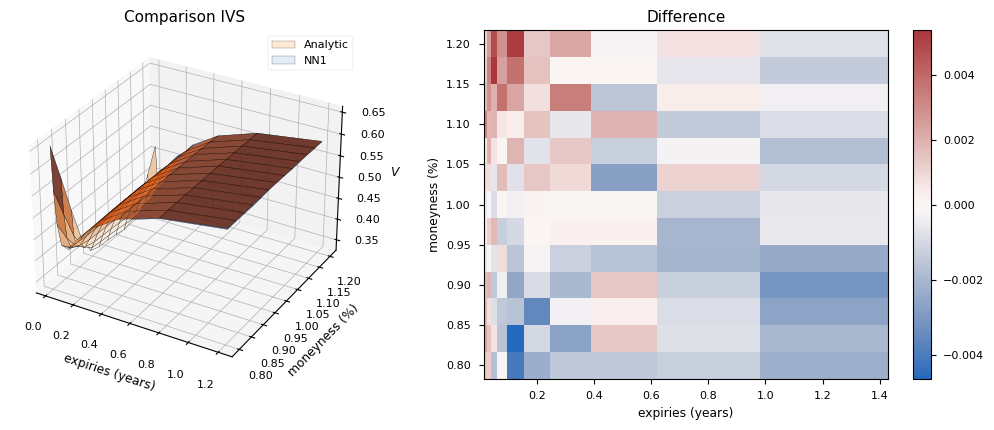

In [21]:
spot_price = 100

tau_grid = sample_maturities(10)
moneyness_grid = sample_moneyness(13)
jump_means = np.array([0.087]*5)
jump_variances = np.array([0.249]*5)

params = {'r': 0.0068,
          'q': 0.0161,
          'v0': 0.0951,
          'kappa': 5.421,
          'theta': 0.370,
          'sigma': 0.224,
          'rho': -0.242,
          'lambda_p': 0.289}

params.update({f"tau_{i}": tau for i, tau in enumerate(tau_grid, start=1)})
params.update({f"m_{i}": m for i, m in enumerate(moneyness_grid, start=1)})
params.update({f"nu_{i}": nu for i, nu in enumerate(jump_means, start=1)})
params.update({f"delta_{i}": delta for i, delta in enumerate(jump_variances, start=1)})

data_point, generation_params = simulate_ivs_analyticaly(params=params, moneyness_grid=moneyness_grid, tau_grid=tau_grid, 
                         spot_price=spot_price, jump_means=jump_means, jump_variances=jump_variances)

ivs_nn = simulate_ivs_with_neural_network(parameters=params, model=nn1, new_V=None, scaler=scaler_nn1)

# Plot the surface
iv_matrix_analytic = np.array(data_point["implied_vol_surface"]).reshape(len(tau_grid), len(moneyness_grid))
iv_matrix_nn = np.array(ivs_nn.cpu().detach()).reshape(len(tau_grid), len(moneyness_grid))

X, Y = np.meshgrid(np.array(tau_grid) / 365.0, moneyness_grid)

Z_diff = iv_matrix_nn - iv_matrix_analytic

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['grid.linewidth'] = 0.5  # try a value like 0.1 instead of 0.01
plt.rcParams['axes.titlesize'] = 11
fig = plt.figure(figsize=plt.figaspect(0.4))

# 3D Surface Plot
ax1: Axes3D = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_surface(X, Y, iv_matrix_analytic.T, cmap='Oranges', alpha=0.7, edgecolor='k', linewidth=0.2)
surf2 = ax1.plot_surface(X, Y, iv_matrix_nn.T, cmap='Blues', alpha=0.7, edgecolor='k', linewidth=0.2)
ax1.set_xlabel("expiries (years)")
ax1.set_ylabel("moneyness (%)")
# ax1.set_zlim(0.15, 0.58)
ax1.set_zlabel("$V$")
ax1.set_title("Comparison IVS")
ax1.legend(["Analytic", "NN1"], framealpha=1)
print(ax1._get_view())
# cbar1 = fig.colorbar(surf1, ax=ax1, location='right', shrink=0.6, pad=0.12, cmap="Oranges")
# cbar1.set_ticks(np.round(np.linspace(iv_matrix_analytic.min(), 0.48, 5), 2))
# cbar2 = fig.colorbar(surf2, ax=ax1, location='right', shrink=0.6, pad=0.12, cmap="Blues")
# cbar2.set_ticks(np.round(np.linspace(iv_matrix_nn.min(), 0.475, 5), 2))
# ax1.view_init(azim=90)


# Heatmap
ax2 = fig.add_subplot(122)
# plt.pcolormesh
# im = ax2.imshow(Z_diff, aspect=4, interpolation='auto', interpolation_stage='data', origin='lower', cmap="coolwarm",
                    # extent=(X.min(), X.max(), Y.min(), Y.max()))
norm = colors.TwoSlopeNorm(vcenter=0)
im  = ax2.pcolormesh(
    X, Y, Z_diff.T,
    cmap='vlag',  # A perceptually uniform colormap ideal for continuous data
    shading='auto', norm=norm
)
cbar_diff = fig.colorbar(im, ax=ax2)
# cbar_diff.set_label("Difference")
# cbar_diff.set_ticks(np.round(np.linspace(Z_diff.min(), Z_diff.max(), 5), 4))
ax2.set_xlabel("expiries (years)")
ax2.set_ylabel("moneyness (%)")
ax2.set_title("Difference")

plt.tight_layout()
# plt.savefig("nn1_case2.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

#### 3rd Case

({'xlim': (np.float64(-0.06732305936073059), np.float64(1.2919805936073059)), 'autoscalex_on': True, 'ylim': (np.float64(0.7708333333333334), np.float64(1.2291666666666667)), 'autoscaley_on': True, 'zlim': (np.float64(0.24366437581678232), np.float64(0.6458366891990105)), 'autoscalez_on': True}, (30, -60, 0))


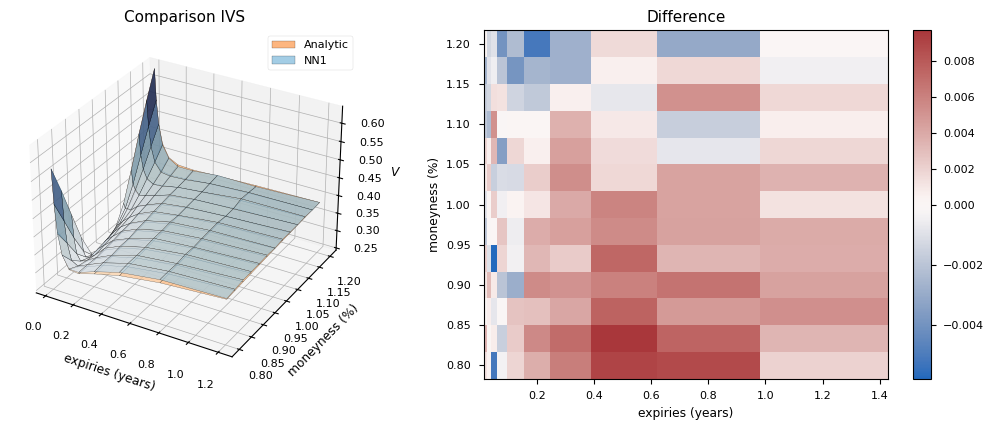

In [ ]:
spot_price = 100

tau_grid = sample_maturities(10)
moneyness_grid = sample_moneyness(13)
jump_means = np.array([-0.202]*5)
jump_variances = np.array([0.287]*5)

params = {'r': 0.0111,
          'q': 0.0021,
          'v0': 0.0552,
          'kappa': 8.698,
          'theta': 0.106,
          'sigma': 0.391,
          'rho': -0.12,
          'lambda_p': 0.491}

params.update({f"tau_{i}": tau for i, tau in enumerate(tau_grid, start=1)})
params.update({f"m_{i}": m for i, m in enumerate(moneyness_grid, start=1)})
params.update({f"nu_{i}": nu for i, nu in enumerate(jump_means, start=1)})
params.update({f"delta_{i}": delta for i, delta in enumerate(jump_variances, start=1)})

data_point, generation_params = simulate_ivs_analyticaly(params=params, moneyness_grid=moneyness_grid, tau_grid=tau_grid, 
                         spot_price=spot_price, jump_means=jump_means, jump_variances=jump_variances)

ivs_nn = simulate_ivs_with_neural_network(parameters=params, model=nn1, new_V=None, scaler=scaler_nn1)

# Plot the surface
iv_matrix_analytic = np.array(data_point["implied_vol_surface"]).reshape(len(tau_grid), len(moneyness_grid))
iv_matrix_nn = np.array(ivs_nn.cpu().detach()).reshape(len(tau_grid), len(moneyness_grid))

X, Y = np.meshgrid(np.array(tau_grid) / 365.0, moneyness_grid)

Z_diff = iv_matrix_nn - iv_matrix_analytic

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['grid.linewidth'] = 0.5  # try a value like 0.1 instead of 0.01
plt.rcParams['axes.titlesize'] = 11
fig = plt.figure(figsize=plt.figaspect(0.4))

# 3D Surface Plot
ax1: Axes3D = fig.add_subplot(121, projection='3d')

surf1 = ax1.plot_surface(X, Y, iv_matrix_analytic.T, cmap='Oranges', alpha=0.7, edgecolor='k', linewidth=0.2)
surf2 = ax1.plot_surface(X, Y, iv_matrix_nn.T, cmap='Blues', alpha=0.7, edgecolor='k', linewidth=0.2)
ax1.set_xlabel("expiries (years)")
ax1.set_ylabel("moneyness (%)")
# ax1.set_zlim(0.15, 0.58)
ax1.set_zlabel("$V$")
ax1.set_title("Comparison IVS")
ax1.legend(["Analytic", "NN1"], framealpha=1)
print(ax1._get_view())
# cbar1 = fig.colorbar(surf1, ax=ax1, location='right', shrink=0.6, pad=0.12, cmap="Oranges")
# cbar1.set_ticks(np.round(np.linspace(iv_matrix_analytic.min(), 0.48, 5), 2))
# cbar2 = fig.colorbar(surf2, ax=ax1, location='right', shrink=0.6, pad=0.12, cmap="Blues")
# cbar2.set_ticks(np.round(np.linspace(iv_matrix_nn.min(), 0.475, 5), 2))
# ax1.view_init(azim=90)


# Heatmap
ax2 = fig.add_subplot(122)
# plt.pcolormesh
# im = ax2.imshow(Z_diff, aspect=4, interpolation='auto', interpolation_stage='data', origin='lower', cmap="coolwarm",
                    # extent=(X.min(), X.max(), Y.min(), Y.max()))
                    
norm = colors.TwoSlopeNorm(vcenter=0)
im  = ax2.pcolormesh(
    X, Y, Z_diff.T,
    cmap='vlag',  # A perceptually uniform colormap ideal for continuous data
    shading='auto', norm= norm
)
cbar_diff = fig.colorbar(im, ax=ax2)

# cbar_diff.set_label("Difference")
# cbar_diff.set_ticks(np.round(np.linspace(Z_diff.min(), Z_diff.max(), 5), 4))
ax2.set_xlabel("expiries (years)")
ax2.set_ylabel("moneyness (%)")
ax2.set_title("Difference")

plt.tight_layout()
plt.savefig("nn1_case3.png", dpi=300, format='png', bbox_inches='tight')
plt.show()

## Performance Comparison in IVS Generation

In [143]:
spot_price = 100

tau_grid = sample_maturities(10)
moneyness_grid = sample_moneyness(13)
jump_means = np.array([0.087]*5)
jump_variances = np.array([0.249]*5)

params = {'r': 0.0068,
          'q': 0.0161,
          'v0': 0.0951,
          'kappa': 5.421,
          'theta': 0.370,
          'sigma': 0.224,
          'rho': 0.242,
          'lambda_p': 0.289}

params.update({f"tau_{i}": tau for i, tau in enumerate(tau_grid, start=1)})
params.update({f"m_{i}": m for i, m in enumerate(moneyness_grid, start=1)})
params.update({f"nu_{i}": nu for i, nu in enumerate(jump_means, start=1)})
params.update({f"delta_{i}": delta for i, delta in enumerate(jump_variances, start=1)})

In [144]:
%%timeit
data_point, generation_params = simulate_ivs_analyticaly(params=params, moneyness_grid=moneyness_grid, tau_grid=tau_grid, 
                         spot_price=spot_price, jump_means=jump_means, jump_variances=jump_variances)

28.9 ms ± 175 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [145]:
%%timeit
ivs_nn = simulate_ivs_with_neural_network(parameters=params, model=nn1, new_V=None, scaler=scaler_nn1)

1.2 ms ± 167 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
